In [3]:
!pip install opencv-python

     ---------------------------------------- 38.8/38.8 MB 1.2 MB/s eta 0:00:00


In [5]:
!pip install tensorflow

     ------------------------------------ 376.9/376.9 MB 735.6 kB/s eta 0:00:00
     -------------------------------------- 57.5/57.5 kB 605.5 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 787.2 kB/s eta 0:00:00
     ---------------------------------------- 26.4/26.4 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 1.3 MB/s eta 0:00:00
     -------------------------------------- 127.8/127.8 kB 2.5 MB/s eta 0:00:00
     -------------------------------------- 413.4/413.4 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
     -------------------------------------- 133.7/133.7 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 838.9 kB/s eta 0:00:00
     ------------------------------------ 240.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import LabelEncoder



In [2]:
# Load the datasets
recognition_df = pd.read_csv('Licplatesrecognition_train.csv')
detection_df = pd.read_csv('Licplatesdetection_train.csv')

# Data exploration and visualization
print("License Plates Recognition Data")
print(recognition_df.head())

print("\nLicense Plates Detection Data")
print(detection_df.head())

License Plates Recognition Data
    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979

License Plates Detection Data
    img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222


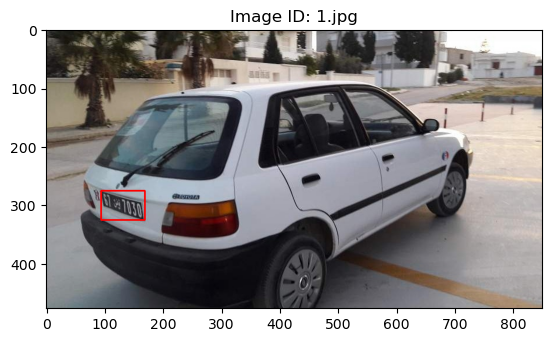

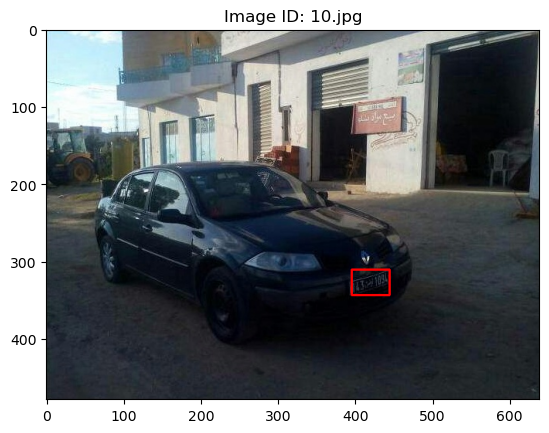

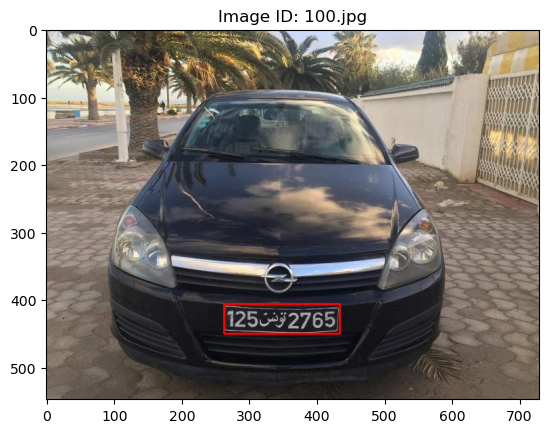

In [3]:
# Load and visualize a few images
def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Example: Display some car images with bounding boxes
for i in range(3):
    img_id = detection_df.iloc[i]['img_id']
    img_path = f'license_plates_detection_train/{img_id}'
    img = load_image(img_path)
    
    ymin, xmin, ymax, xmax = detection_df.iloc[i][['ymin', 'xmin', 'ymax', 'xmax']]
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f'Image ID: {img_id}')
    plt.show()


In [5]:
# Preprocess the images for detection and recognition
def preprocess_detection_data(detection_df, img_folder):
    images = []
    boxes = []
    
    for idx, row in detection_df.iterrows():
        img_id = row['img_id']
        img_path = f'{img_folder}/{img_id}'
        img = load_image(img_path)
        img_resized = cv2.resize(img, (224, 224))
        
        images.append(img_resized)
        boxes.append([row['ymin'], row['xmin'], row['ymax'], row['xmax']])
    
    return np.array(images), np.array(boxes)

detection_images, detection_boxes = preprocess_detection_data(detection_df, 'license_plates_detection_train')



In [6]:
# Split data into training and validation sets
train_imgs, val_imgs, train_boxes, val_boxes = train_test_split(detection_images, detection_boxes, test_size=0.2, random_state=42)

# Define the model for license plate detection
def build_detection_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(4, activation='linear')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')
    
    return model

detection_model = build_detection_model()
detection_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,409,924 (154.15 MB)

 Trainable params: 40,409,924 (154.15 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the detection model
history = detection_model.fit(train_imgs, train_boxes, epochs=20, validation_data=(val_imgs, val_boxes), batch_size=16)

# Preprocess the images for recognition
def preprocess_recognition_data(recognition_df, img_folder):
    images = []
    labels = []
    
    for idx, row in recognition_df.iterrows():
        img_id = row['img_id']
        img_path = f'{img_folder}/{img_id}'
        img = load_image(img_path)
        img_resized = cv2.resize(img, (128, 64))
        
        images.append(img_resized)
        labels.append(row['text'])
    
    return np.array(images), np.array(
        labels)

recognition_images, recognition_labels = preprocess_recognition_data(recognition_df, 'license_plates_recognition_train')



Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 486s 11s/step - loss: 115015.1875 - val_loss: 11228.1523
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 482s 11s/step - loss: 7956.3843 - val_loss: 5101.0342
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 488s 11s/step - loss: 4074.3140 - val_loss: 4491.7397
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 461s 10s/step - loss: 2827.3586 - val_loss: 3887.6108
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 428s 10s/step - loss: 2008.2787 - val_loss: 3671.4500
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 405s 9s/step - loss: 1425.0553 - val_loss: 3516.5791
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 433s 10s/step - loss: 992.2924 - val_loss: 3534.1384
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 438s 10s/step - loss: 637.8172 - val_loss: 3462.4463
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 429s 9s/step - loss: 369.1899 - val_loss: 3537.0483
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 429s 10s/step - loss: 309.4948 - val_loss: 3367.0249
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 433s 10s/step - loss: 179.5739 - val_loss: 

In [34]:
# Save the detection model
detection_model_path = 'detection_model.h5'
detection_model.save(detection_model_path)
print(f"Detection model saved to {detection_model_path}")



Detection model saved to detection_model.h5


In [14]:
# Split data into training and validation sets
train_imgs, val_imgs, train_labels, val_labels = train_test_split(recognition_images, recognition_labels, test_size=0.2, random_state=42)

# Encode labels using one-hot encoding or integer encoding
label_encoder = LabelEncoder()
all_labels = np.concatenate([train_labels, val_labels])
label_encoder.fit(all_labels)
train_labels_enc = label_encoder.transform(train_labels)
val_labels_enc = label_encoder.transform(val_labels)

In [40]:
# Define the model for license plate recognition
def build_recognition_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

recognition_model = build_recognition_model()
recognition_model.summary()

# Train the recognition model
history = recognition_model.fit(train_imgs, train_labels_enc, epochs=20, validation_data=(val_imgs, val_labels_enc), batch_size=16)


C:\Users\muthu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 62, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 26880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,440,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 596)            │        76,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,537,044 (13.49 MB)

 Trainable params: 3,537,044 (13.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.0010 - loss: 16.1506 - val_accuracy: 0.0000e+00 - val_loss: 6.3911
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.0033 - loss: 6.3894 - val_accuracy: 0.0000e+00 - val_loss: 6.3974
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.0056 - loss: 6.3902 - val_accuracy: 0.0000e+00 - val_loss: 6.3942
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.0125 - loss: 6.3878 - val_accuracy: 0.0000e+00 - val_loss: 6.3958
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.0028 - loss: 6.3871 - val_accuracy: 0.0000e+00 - val_loss: 6.3973
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.0082 - loss: 6.3865 - val_accuracy: 0.0222 - val_loss: 6.3988
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.0097 - loss: 6.3856 - val_accuracy: 0.0222 - val_loss: 6.4003
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.0089 - loss: 6.3848 - val

In [41]:
# Save the recognition model
recognition_model.summary()
recognition_model.save('recognition_model.h5')
print("Recognition model saved.")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 62, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 26880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,440,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 596)            │        76,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,611,134 (40.48 MB)

 Trainable params: 3,537,044 (13.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,074,090 (26.99 MB)

Recognition model saved.


In [43]:
import os
import cv2
import numpy as np
import pandas as pd

def predict_on_test_set(test_img_folder, detection_model, recognition_model, label_encoder):
    results = []
    
    for img_filename in os.listdir(test_img_folder):
        try:
            img_path = os.path.join(test_img_folder, img_filename)
            img = load_image(img_path)
            
            if img is None:
                print(f"Error loading image: {img_path}")
                continue
            
            img_resized = cv2.resize(img, (224, 224))
            
            # Perform object detection to get the bounding box
            box = detection_model.predict(np.expand_dims(img_resized, axis=0))[0]
            ymin, xmin, ymax, xmax = map(int, box)
            
            # Extract the license plate region and resize for recognition
            license_plate_img = img[ymin:ymax, xmin:xmax]
            license_plate_img_resized = cv2.resize(license_plate_img, (128, 64))
            
            # Perform recognition on the license plate region
            pred_label_enc = recognition_model.predict(np.expand_dims(license_plate_img_resized, axis=0))
            pred_label = label_encoder.inverse_transform([np.argmax(pred_label_enc)])
            
            # Collect results
            results.append({'img_id': img_filename, 'pred_text': pred_label[0]})
        
        except Exception as e:
            print(f"Error processing image {img_filename}: {str(e)}")
    
    return results

# Assuming label_encoder is already defined and fitted

# Perform detection and recognition on the test set
test_img_folder = 'test'  # Replace with your test image folder path
results = predict_on_test_set(test_img_folder, detection_model, recognition_model, label_encoder)

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv('test_results.csv', index=False)

print("Test results saved to 'test_results.csv'.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step